## BitLinearLayer

Criando um código agnóstico de hardware

In [1747]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Verificando se tem GPU

In [1748]:
print(f"Device: {device}")
if device == "cuda":
    !nvidia-smi

Device: cuda
Sun Oct 20 19:08:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150           On  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8              N/A / ERR! |    158MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------------

Garantindo reprodutibilidade do experimento

In [1749]:
DEFAULT_SEED = 42

def set_seed(seed = DEFAULT_SEED):
    if seed:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

In [1750]:
set_seed()
x = torch.randn(1, 1, 4)
x, x.shape

(tensor([[[0.3367, 0.1288, 0.2345, 0.2303]]]), torch.Size([1, 1, 4]))

In [1751]:
from bitnet import BitLinear

set_seed()
bit_layer = BitLinear(4, 2)
y = bit_layer(x)
print(y)

tensor([[[ 0.1261, -0.1275]]], grad_fn=<UnsafeViewBackward0>)


In [1752]:
from torch.nn import Linear

set_seed()
linear_layer = Linear(4, 2)
y = linear_layer(x)
print(y)

tensor([[[ 0.7013, -0.3801]]], grad_fn=<ViewBackward0>)


In [1753]:
bit_layer.weight, linear_layer.weight

(Parameter containing:
 tensor([[ 0.3823,  0.4150, -0.1171,  0.4593],
         [-0.1096,  0.1009, -0.2434,  0.2936]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.3823,  0.4150, -0.1171,  0.4593],
         [-0.1096,  0.1009, -0.2434,  0.2936]], requires_grad=True))

In [1754]:
bit_layer.bias, linear_layer.bias

(Parameter containing:
 tensor([ 0.4408, -0.3668], requires_grad=True),
 Parameter containing:
 tensor([ 0.4408, -0.3668], requires_grad=True))

### Dados Sintéticos

Definindo o número de samples e classes que serão gerados

In [1755]:
NUM_SAMPLES = 1555
NUM_CLASSES = 2

Implementações dos geradores de dados sintéticos por grau de complexidade

In [1756]:
from sklearn.datasets import make_blobs

class LinearlySeparableDataGenerator():
    def __init__(self):
        pass

    def generate(self,
        num_samples:int = NUM_SAMPLES, 
        num_classes:int = NUM_CLASSES,
        random_state: int = DEFAULT_SEED):  
        X, y = make_blobs(
                       n_samples = num_samples, 
                       n_features=2,
                       centers=num_classes,
                       cluster_std=2.0,
                       random_state=random_state, 
                       shuffle=True
                       )
        return X, y

# TODO tentar gerar 3 circulos (samples_per_class, 0), incrementar fator sempre,
class NonLinearlySeparableDataGenerator():
    import numpy as np

    def __init__(self):
        pass

 
    def generate(self, 
                 num_samples: int = NUM_SAMPLES, 
                 num_classes:int = NUM_CLASSES,
                 noise=0.05, 
                 factor:int=0.5, 
                 random_state: int = DEFAULT_SEED):
        
        np.random.seed(random_state)
        
        X = []
        y = []

        samples_per_class = num_samples // num_classes
        remainder = num_samples % num_classes

        # Distribute the remainder to one of the classes randomly or to the first if reproducible
        extra_samples = [1 if i < remainder else 0 for i in range(num_classes)]
        
        # Generate each class as a circle with increasing radius
        for i in range(num_classes):
            # Adjust the number of samples for this class considering the remainder
            adjusted_num_samples = samples_per_class + extra_samples[i]
            radius = factor * (i + 1)  # Incremental radius for each class
            theta = np.linspace(0, 2 * np.pi, adjusted_num_samples)
            x_circle = radius * np.cos(theta) + np.random.normal(scale=noise, size=adjusted_num_samples)
            y_circle = radius * np.sin(theta) + np.random.normal(scale=noise, size=adjusted_num_samples)
            
            X.append(np.vstack((x_circle, y_circle)).T)
            y += [i] * adjusted_num_samples  # Class labels
        
        X = np.vstack(X)
        y = np.array(y)
        
        return X, y

class MixedAndUnbalancedDataGenerator():
    def __init__(self):
        pass

    def generate(self,
                 num_samples = NUM_SAMPLES, 
                 n_features=2, # TODO tornar possível especificar o número de features
                 random_state: int = DEFAULT_SEED):
        n_samples_1 = int(num_samples * 0.7)
        n_samples_2 = num_samples - n_samples_1
        centers = [[0.0, 0.0], [2.0, 2.0]]
        clusters_std = [1.5, 0.5]
        X, y = make_blobs(
            n_samples=[n_samples_1, n_samples_2],
            centers=centers,
            cluster_std=clusters_std,
            random_state=random_state,
            shuffle=True,
        )
        return X, y

Selecionando dados do experimento

In [1757]:
SYNTHETIC_DATA_GENERATOR = NonLinearlySeparableDataGenerator()

X, y = SYNTHETIC_DATA_GENERATOR.generate()

In [1758]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y)

In [1759]:
print(f"Foram geradas um total de {len(X)} amostras!")
print("Exibindo o primeiro exemplo do dataset:")
print(f"features: [{X[0, 0]}, {X[0, 1]}]")
print(f"label: {y[0]}")

Foram geradas um total de 1555 amostras!
Exibindo o primeiro exemplo do dataset:
features: [0.5248357057571411, -0.003721671411767602]
label: 0


In [1760]:
import pandas as pd

df = pd.DataFrame({"features": X[:, 0], "label": y})
df["label"].value_counts()

label
0    778
1    777
Name: count, dtype: int64

Listagem de classes geradas

In [1761]:
np.unique(y)

array([0, 1])

Visualizando os dados do dataset gerado

Text(0.5, 1.0, 'Explorando dados do dataset gerado')

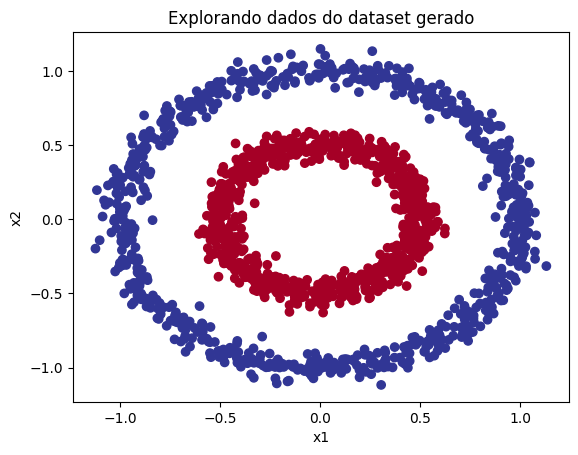

In [1762]:
import matplotlib.pyplot as plt

#plt.style.use('default')
#plt.rcParams.update({'font.size': 8})

plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c = y, 
            cmap=plt.cm.RdYlBu)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title(f"Explorando dados do dataset gerado")

Divisão dos dados de treinamento e teste

In [1763]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=DEFAULT_SEED)

In [1764]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(X_train.shape, y_train.shape)

1244 1244
311 311
torch.Size([1244, 2]) torch.Size([1244])


In [1765]:
print(X_train[0], y_train[0])
print(X_test[0], y_test[0])

tensor([-1.0010, -0.2944]) tensor(1)
tensor([-0.0153, -1.0011]) tensor(1)


### Datasets & Dataloaders

In [1766]:
from torch.utils.data import Dataset
from typing import Tuple

class CustomDataset(Dataset):
    def __init__(self, features: list, 
                        targets: list, 
                        transform = None, 
                        target_transform = None,
                        dtype = torch.float):
        super().__init__()
        self.features = features
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform
        self.dtype = dtype

    def __getitem__(self, idx):
        feature, target = self.features[idx], self.targets[idx]
        
        feature = torch.tensor(feature, 
                               dtype=self.dtype)
        
        target = torch.tensor(target)
        
        if self.transform:
            feature = self.transform(feature)
        if self.target_transform:
            target = self.target_transform(target)
        return feature, target
    
    def __len__(self):
        return len(self.targets)

Transformando dados de treinamento e teste em datasets

In [1767]:
train_dataset = CustomDataset(features = X_train, 
                              targets = y_train)

test_dataset = CustomDataset(features = X_test, 
                             targets = y_test)

print(len(train_dataset), len(test_dataset))
print(train_dataset[0][0], test_dataset[0][1])

1244 311
tensor([-1.0010, -0.2944]) tensor(1)


Parâmetros para criação dos dataloaders, sendo o BATCH_SIZE um hiperparâmetro do treinamento

In [1768]:
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

Definindo dataloaders de treinamento e teste a partir dos datasets

In [1769]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              # reordena exemplos a cada época
                              shuffle = True,
                              num_workers = NUM_WORKERS)

test_dataloader = DataLoader(dataset = test_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = False, 
                              num_workers = NUM_WORKERS)

len(train_dataloader), len(test_dataloader)

(39, 10)

In [1770]:
train_batch_features, train_batch_labels = next(iter(train_dataloader))

print(len(train_batch_features), len(train_batch_labels))
print(train_batch_features[0], train_batch_labels[0])

32 32
tensor([ 0.0153, -0.6290]) tensor(0)


### Arquitetura dos Modelos

Modelo base utilizando camadas nn.Linear

In [1771]:
import torch.nn as nn

class BaseModel(nn.Module):
    def __init__(self, input_size: int, hidden_units: int, output_size: int):
        super().__init__()
        self.name = "Base"
        self.linear_layer1 = nn.Linear(in_features=input_size, out_features=hidden_units)
        self.linear_layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.linear_layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.linear_layer4 = nn.Linear(in_features=hidden_units, out_features=output_size)
        self.activation = nn.Tanh()
    
    def forward(self, x):
        x = self.linear_layer1(x)
        x = self.activation(x)
        x = self.linear_layer2(x)
        x = self.activation(x)
        x = self.linear_layer3(x)
        x = self.activation(x)
        x = self.linear_layer4(x)
        return x


Modelo utilizando camadas binet.BitNetLinear

In [1772]:
import torch.nn as nn

class BitModel(nn.Module):
    def __init__(self, input_size:int, hidden_units:int, output_size:int):
        super().__init__()
        self.name = "Bitnet"
        self.bit_layer1 = BitLinear(in_features=input_size, out_features=hidden_units)
        self.bit_layer2 = BitLinear(in_features=hidden_units, out_features=hidden_units)
        self.bit_layer3 = BitLinear(in_features=hidden_units, out_features=hidden_units)
        self.bit_layer4 = BitLinear(in_features=hidden_units, out_features=output_size)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.bit_layer1(x)
        x = self.activation(x)
        x = self.bit_layer2(x)
        x = self.activation(x)
        x = self.bit_layer3(x)
        x = self.activation(x)
        x = self.bit_layer4(x)
        return x
    

In [1773]:
from torchinfo import summary

In [1774]:
INPUT_SIZE = 2
HIDDEN_UNITS = 5

In [1775]:
base_model = BaseModel(input_size=INPUT_SIZE, 
                     hidden_units=HIDDEN_UNITS, 
                     output_size=NUM_CLASSES
                     ).to(device)
summary(base_model, input_size=(1, 2, ))

Layer (type:depth-idx)                   Output Shape              Param #
BaseModel                                [1, 2]                    --
├─Linear: 1-1                            [1, 5]                    15
├─Tanh: 1-2                              [1, 5]                    --
├─Linear: 1-3                            [1, 5]                    30
├─Tanh: 1-4                              [1, 5]                    --
├─Linear: 1-5                            [1, 5]                    30
├─Tanh: 1-6                              [1, 5]                    --
├─Linear: 1-7                            [1, 2]                    12
Total params: 87
Trainable params: 87
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [1776]:
bit_model = BitModel(input_size=INPUT_SIZE, 
                     hidden_units=HIDDEN_UNITS, 
                     output_size=NUM_CLASSES
                     ).to(device)
summary(bit_model, input_size=(1, 2, ))

Layer (type:depth-idx)                   Output Shape              Param #
BitModel                                 [1, 2]                    --
├─BitLinear: 1-1                         [1, 5]                    15
├─Tanh: 1-2                              [1, 5]                    --
├─BitLinear: 1-3                         [1, 5]                    30
├─Tanh: 1-4                              [1, 5]                    --
├─BitLinear: 1-5                         [1, 5]                    30
├─Tanh: 1-6                              [1, 5]                    --
├─BitLinear: 1-7                         [1, 2]                    12
Total params: 87
Trainable params: 87
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### Treinamento dos Modelos

In [1777]:
from tqdm.auto import tqdm
from torchmetrics.classification import Accuracy

DEFAULT_ACCURACY = Accuracy(task="multiclass", 
                            num_classes=NUM_CLASSES)

def train_step(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          criteria: torch.nn.Module,
          metrics: Accuracy = DEFAULT_ACCURACY,
          optimizer = None,
          device: str = device):
    
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        y_logits = model(X)

        loss = criteria(y_logits, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        train_acc += metrics(torch.argmax(y_logits, dim = 1).cpu(), y.cpu())

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              criteria: torch.nn.Module, 
              metrics: Accuracy = DEFAULT_ACCURACY, 
              device: str = device):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for test_batch, (X_test, y_test) in enumerate(test_dataloader):
            X_test, y_test = X_test.to(device), y_test.to(device)

            y_logits_test = model(X_test.to(device)).squeeze()
            
            test_loss += criteria(y_logits_test, y_test).item()
            test_acc += metrics(torch.argmax(y_logits_test, dim = 1).cpu(), y_test.cpu())

    test_loss = test_loss / len(dataloader)    
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc



def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          num_epochs: int,
          criteria: torch.nn.Module,
          metrics: Accuracy = DEFAULT_ACCURACY,
          optimizer = None,
          device: str = device):
    
    results = {
        "model_name": str(model.name), "lr": optimizer.param_groups[0]["lr"],
        "criteria": criteria, "batch_size": train_dataloader.batch_size,
        "train_loss": [], "train_acc": [],  "test_loss": [], "test_acc": []
    }

    model.to(device)


    for epoch in tqdm(range(num_epochs)):


        # treinamento do modelo por uma época
        train_loss, train_acc = train_step(model = model,
                                           dataloader = train_dataloader,
                                           criteria = criteria,
                                           metrics = metrics,
                                           optimizer = optimizer,
                                           device = device)

        # avaliando modelo nos dados de teste
        test_loss, test_acc = test_step(model = model, 
                                        dataloader = test_dataloader, 
                                        criteria = criteria, 
                                        metrics = metrics, 
                                        device = device)

        # exibindo métricas de treinamento e teste
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results



Definição de parâmetros de treinamento

In [1778]:
EPOCHS = 20
LEARNING_RATE = 1e-3

Definindo da loss e otimizador para rede BitNet

In [1779]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=bit_model.parameters(), lr=LEARNING_RATE)

In [1780]:
bit_results = train(model = bit_model, 
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                num_epochs=EPOCHS,
                criteria=criteria,
                optimizer=optimizer,
                device = device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.6976, Train Acc: 0.49% | Test Loss: 0.6896, Test Acc: 0.54%
Epoch: 1 | Train Loss: 0.6967, Train Acc: 0.49% | Test Loss: 0.6938, Test Acc: 0.52%
Epoch: 2 | Train Loss: 0.6947, Train Acc: 0.49% | Test Loss: 0.6938, Test Acc: 0.52%
Epoch: 3 | Train Loss: 0.6940, Train Acc: 0.49% | Test Loss: 0.6938, Test Acc: 0.52%
Epoch: 4 | Train Loss: 0.6941, Train Acc: 0.49% | Test Loss: 0.6954, Test Acc: 0.46%
Epoch: 5 | Train Loss: 0.6930, Train Acc: 0.51% | Test Loss: 0.6954, Test Acc: 0.46%
Epoch: 6 | Train Loss: 0.6930, Train Acc: 0.51% | Test Loss: 0.6954, Test Acc: 0.46%
Epoch: 7 | Train Loss: 0.6930, Train Acc: 0.51% | Test Loss: 0.6954, Test Acc: 0.46%
Epoch: 8 | Train Loss: 0.6928, Train Acc: 0.51% | Test Loss: 0.6970, Test Acc: 0.46%
Epoch: 9 | Train Loss: 0.6927, Train Acc: 0.51% | Test Loss: 0.6970, Test Acc: 0.46%
Epoch: 10 | Train Loss: 0.6932, Train Acc: 0.50% | Test Loss: 0.6970, Test Acc: 0.46%
Epoch: 11 | Train Loss: 0.6926, Train Acc: 0.51% | Test Loss: 0.

Definindo loss e otimizador para a rede Baseline

In [1781]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=base_model.parameters(), lr=LEARNING_RATE)

In [1782]:
base_results = train(model = base_model, 
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                num_epochs=EPOCHS,
                criteria=criteria,
                optimizer=optimizer,
                device = device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.7080, Train Acc: 0.51% | Test Loss: 0.7009, Test Acc: 0.48%
Epoch: 1 | Train Loss: 0.6933, Train Acc: 0.47% | Test Loss: 0.6904, Test Acc: 0.42%
Epoch: 2 | Train Loss: 0.6895, Train Acc: 0.47% | Test Loss: 0.6879, Test Acc: 0.57%
Epoch: 3 | Train Loss: 0.6878, Train Acc: 0.57% | Test Loss: 0.6871, Test Acc: 0.54%
Epoch: 4 | Train Loss: 0.6858, Train Acc: 0.63% | Test Loss: 0.6842, Test Acc: 0.74%
Epoch: 5 | Train Loss: 0.6832, Train Acc: 0.73% | Test Loss: 0.6806, Test Acc: 0.83%
Epoch: 6 | Train Loss: 0.6789, Train Acc: 0.78% | Test Loss: 0.6756, Test Acc: 0.83%
Epoch: 7 | Train Loss: 0.6727, Train Acc: 0.80% | Test Loss: 0.6684, Test Acc: 0.79%
Epoch: 8 | Train Loss: 0.6651, Train Acc: 0.76% | Test Loss: 0.6595, Test Acc: 0.81%
Epoch: 9 | Train Loss: 0.6543, Train Acc: 0.78% | Test Loss: 0.6484, Test Acc: 0.81%
Epoch: 10 | Train Loss: 0.6409, Train Acc: 0.81% | Test Loss: 0.6331, Test Acc: 0.83%
Epoch: 11 | Train Loss: 0.6241, Train Acc: 0.83% | Test Loss: 0.

### Resultados do Experimento

In [1783]:
def plot_results(results: dict):
    fig, (ax1, ax2) = plt.subplots(nrows=1, 
                                   ncols=2, 
                                   sharex=True, 
                                   figsize=(9, 4))
    fig.suptitle(f"Performance do modelo {results['model_name']}",
                 fontsize="x-large")
    ax1.plot(results["train_loss"], label = "Train")
    ax1.plot(results["test_loss"], label = "Test")
    ax1.set_title("Loss", fontsize = 'large')
    ax1.set_xlabel("Epochs")
    ax2.plot(results["train_acc"], label = "Train")
    ax2.plot(results["test_acc"], label = "Test")
    ax2.set_title("Accuracy", fontsize = 'large')
    ax2.set_xlabel("Epochs")
    plt.legend()

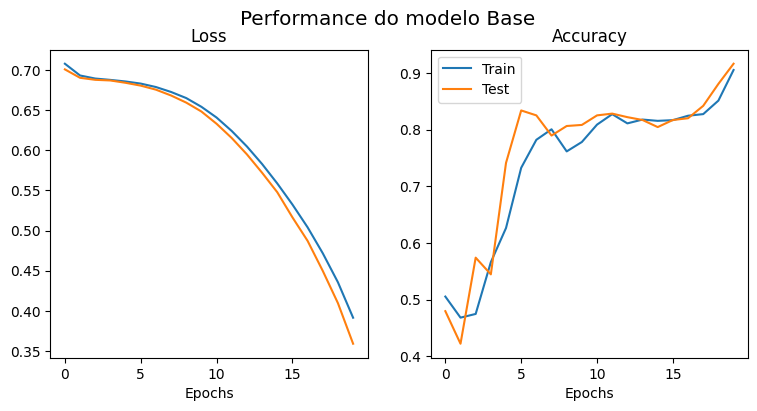

In [1784]:
# exibindo performance do modelo base
plot_results(results = base_results)

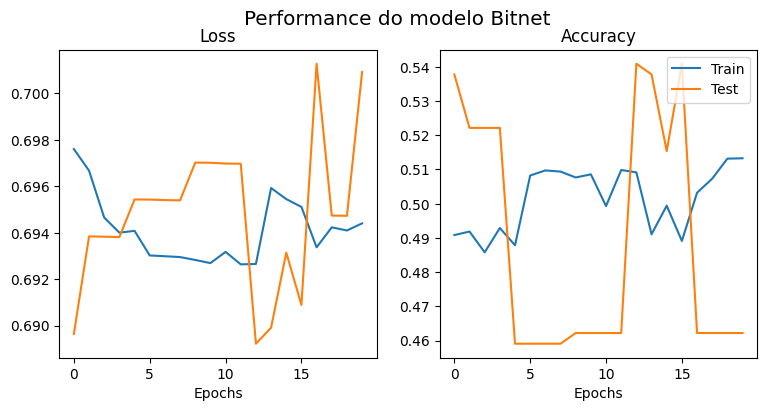

In [1785]:
# exibindo performance do modelo bitnet
plot_results(results = bit_results)

Baixando funções auxiliares para visualização das regiões de separação dos modelos

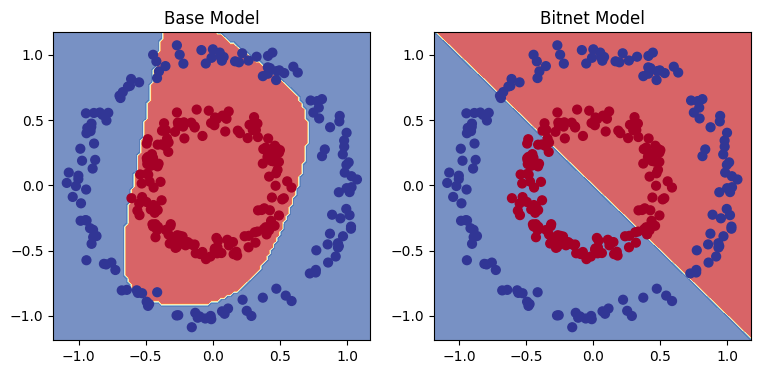

In [1786]:
from utils import plot_decision_boundary
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.title(f"{base_model.name} Model")
plot_decision_boundary(base_model, X_test, y_test)
plt.subplot(1, 2, 2)
plt.title(f"{bit_model.name} Model")
plot_decision_boundary(bit_model, X_test, y_test)